<a href="https://colab.research.google.com/github/eshraongithub/11MBIG_Trabajo_Fin_de_Master_Big_Data_y_Data_Science/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation

This notebook aims to analyse the purchases made by approximately 4,000 customers from an E-commerce in a period of one year (from 01/12/2010 to 09/12/2011). Based on this analysis, we develop a model that allows anticipating the purchases that will be made by new customers during the following year, based on the customer's first purchase.

**Acknowledgement**: This work has been adapted from Fabien Daniel's "[Customer Segmentation](https://www.kaggle.com/fabiendaniel/customer-segmentation)" notebook published on Kaggle.

**1. Data Preparation**

**2. Exploring the content of variables**

**2.1 Countries**

2.2 Customers and products

2.2.1 Cancelling orders

2.2.2 StockCode

2.2.3 Basket price

**3. Insight on product categories**

3.1 Product description

3.2 Defining product categories

3.2.1 Data encoding

3.2.2 Clusters of products

3.2.3 Characterizing the content of clusters

**4. Customer categories**

4.1 Formating data

4.1.1 Grouping products

4.1.2 Time spliting of the dataset

4.1.3 Grouping orders

4.2 Creating customer categories

4.2.1 Data enconding

4.2.2 Creating categories

**5. Classifying customers**

5.1 Support Vector Machine Classifier (SVC)

5.1.1 Confusion matrix

5.1.2 Leraning curves

5.2 Logistic regression

5.3 k-Nearest Neighbors

5.4 Decision Tree

5.5 Random Forest

5.6 AdaBoost

5.7 Gradient Boosting Classifier

5.8 Let's vote!

**6. Testing the predictions**

**7. Conclusion**

## 0. Preliminary Settings

Before starting any analysis, we make sure that the basic and general-use libraries (numpy, pandas, etc.) are correctly imported.

We import the libraries including the Matplotlib-based statistical data visualization package "seaborn" to make graphs from our data.

In [1]:
#@title
# data upload
import pandas as pd
import io
# data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import datetime
import plotly.graph_objs as go
from plotly.offline import iplot
import nltk
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from wordcloud import WordCloud
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.model_selection import learning_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn import neighbors
from sklearn.svm import LinearSVC

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1. Data preparation

We load the two datasets that have been uploaded to Google Drive via PyDrive and follow the authentication process to allow Google to access our Google Drive.

In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Then we load the two CSV data files into the Google Colab environment to DataFrames.

In [3]:
#@title
id_year_2009_2010= '1a_nf0l7wJ7PJ-jWlpKfyLkrLAMfhTI5R'
id_year_2010_2011= '1hAdAIgfi4OPPtP6U3j3v-zFBoxP8KwR4'
downloaded_2009_2010 = drive.CreateFile({'id':id_year_2009_2010})
downloaded_2010_2011 = drive.CreateFile({'id':id_year_2010_2011})
downloaded_2009_2010.GetContentFile('year_2009_2010.csv')
downloaded_2010_2011.GetContentFile('year_2010_2011.csv')
# We store the data in DataFrames
year_2009_2010 = pd.read_csv('year_2009_2010.csv',
                         dtype={'Customer ID': object})
year_2010_2011 = pd.read_csv('year_2010_2011.csv',
                         dtype={'Customer ID': object})
# We append the two DataFrames
online_retail = year_2009_2010.append(year_2010_2011, ignore_index=True)

# And we convert the data type of the InvoiceDate column to datetime
online_retail['InvoiceDate'] = pd.to_datetime(online_retail['InvoiceDate'])

We confirm that the two datasets were appended and that all records were loaded.

In [4]:
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   object        
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 65.1+ MB


In [5]:
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-01-12 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-01-12 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-01-12 07:45:00,1.25,13085,United Kingdom


And it's always a good practice to review data types.
As you can see, most of the columns are strings marked as objects.

In [6]:
online_retail.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

Next, we review the data types and the number of null values and their percentage with respect to the total number of entries.

In [7]:
# We reveiew the data types and the number and percentage of null values
tab_info= pd.DataFrame(online_retail.dtypes).T.rename(index={0:'column type'})
tab_info= tab_info.append(pd.DataFrame(online_retail.isnull().sum()).T.rename(index={0:'number of null values'}))
tab_info= tab_info.append(pd.DataFrame(online_retail.isnull().sum()/online_retail.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
number of null values,0,0,4382,0,0,0,243007,0
null values (%),0,0,0.410541,0,0,0,22.7669,0


While looking at the number of null values in the dataframe, it is interesting to note that almost 23% of the entries are not assigned to a particular customer. Since these entries are useless for the current exercise, we remove all null values from the dataframe and confirm that no null values are left in the dataframe.

In [8]:
online_retail.dropna(axis = 0, subset = ['Customer ID'], inplace = True)
print('Dataframe dimensions:', online_retail.shape)

# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(online_retail.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(online_retail.isnull().sum()).T.rename(index={0:'number of null values'}))
tab_info=tab_info.append(pd.DataFrame(online_retail.isnull().sum()/online_retail.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (824364, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
number of null values,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


Finally, we check for duplicate entries and remove them.

In [9]:
print('Duplicate entries removed: {}'.format(online_retail.duplicated().sum()))
online_retail.drop_duplicates(inplace = True)

Duplicate entries removed: 26479


And we see that after removing null values and duplicates we are left with almost 800K observations from the original dataset to work with.

In [10]:
len(online_retail)

797885

## 2. Exploring the content of variables

The original dataframe contains 8 variables that correspond to:
*   Invoice: Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. Nominal.
*   StockCode: Product (item) code. A 5-digit integral number uniquely assigned to each distinct product. Nominal.
*   Description: Product (item) name. Nominal.
*   Quantity: The quantities of each product (item) per transaction. Numeric.
*   InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated. Datetime object.
*   Price: Unit price; product price per unit in sterling. Numeric.
*   Customer ID: Customer number. A 5-digit integral number uniquely assigned to each customer. Nominal.
*   Country: Country name. The name of the country where each customer resides. Nominal.


### 2.1 Countries

Here, we count the different number of unique country values and see that clients made the orders from 41 different countries (41 countries in the dataset).

In [11]:
temp = online_retail[['Customer ID', 'Invoice', 'Country']].groupby(['Customer ID', 'Invoice', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of countries in the dataframe: {}'.format(len(countries)))

Number of countries in the dataframe: 41


And we show the number of orders by country on a chloropleth map:

In [12]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Orders'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

And we see that the dataset is largely dominated by orders made from the UK.

### 2.2 Customers and products

With the dataframe currently containing almost 800,000 entries, we check the number of products, transactions and customers that we currently have in the dataframe.

In [13]:
pd.DataFrame([{'products': len(online_retail['StockCode'].value_counts()),    
               'transactions': len(online_retail['Invoice'].value_counts()),
               'customers': len(online_retail['Customer ID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4646,44876,5942


It can be seen that the data has almost 6,000 customers and that they bought 4,646 different products.

The total number of transactions carried out by them is almost 45,000.

Now we will determine the number of products purchased in every transaction:

In [14]:
temp = online_retail.groupby(by=['Customer ID', 'Invoice'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:15].sort_values('Customer ID')

,Customer ID,Invoice,Number of products
0,12346,491725,1
1,12346,491742,1
2,12346,491744,1
3,12346,492718,1
4,12346,492722,1
5,12346,493410,1
6,12346,493412,1
7,12346,494450,1
8,12346,495295,1
9,12346,499763,5


The first lines of this list show:

*   The existence of entries with the prefix C for the Invoice variable; this indicates transactions that have been canceled.
*   The existence of users that buy a large number of items in 1 order.

###2.2.1 Cancelled orders

We calculate the proportion of transactions that were canceled:

In [15]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['Invoice'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:15])

n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,Customer ID,Invoice,Number of products,order_canceled
0,12346,491725,1,0
1,12346,491742,1,0
2,12346,491744,1,0
3,12346,492718,1,0
4,12346,492722,1,0
5,12346,493410,1,0
6,12346,493412,1,0
7,12346,494450,1,0
8,12346,495295,1,0
9,12346,499763,5,0


Number of orders canceled: 7901/44876 (17.61%) 


We note that the number of cancelled transactions is approximately 18% of the total number of transactions.

At this point, we decide to create a new variable in the dataframe that indicate if part of the transaction has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before December 2010 (the point of entry of the dataset). Below, we check for cancelled orders and for the existence of counterparts:

In [16]:
df_cleaned = online_retail.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  online_retail.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = online_retail[(online_retail['Customer ID'] == col['Customer ID']) &
                         (online_retail['StockCode']  == col['StockCode']) & 
                         (online_retail['InvoiceDate'] < col['InvoiceDate']) & 
                         (online_retail['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break

In the above function, we checked the two cases:

*   A cancel order exists without a counterpart
*   There's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the doubtfull_entry and entry_to_remove lists whose sizes are:

In [17]:
print("entries_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entries: {}".format(len(doubtfull_entry)))

entries_to_remove: 13484
doubtfull_entries: 4621


Among these entries, the lines listed in the doubtfull_entry list correspond to the entries indicating a cancellation but for which there is no purchase transaction beforehand. 
In practice, we decide to delete all of the cancelled entries, which count respectively for  ∼ 1.6% and 0.6% of the dataframe entries.

Then, we check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [18]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

# Reset index
df_cleaned.reset_index(drop=True, inplace=True)

remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("number of cancelled entries that have not been deleted: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

number of cancelled entries that have not been deleted: 120


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,QuantityCanceled
6590,C490133,21314,SMALL GLASS HEART TRINKET POT,-504,2009-03-12 18:36:00,1.85,17949,United Kingdom,0
20796,C491728,22139,RETRO SPOT TEA SET CERAMIC 11 PC,-4,2009-12-14 09:18:00,4.95,12471,Germany,0
31283,C493689,79000,MOROCCAN TEA GLASS,-18,2010-05-01 12:45:00,0.85,14606,United Kingdom,0
32645,C493836,84050,PINK HEART SHAPE EGG FRYING PAN,-24,2010-07-01 13:49:00,1.65,12839,United Kingdom,0
46013,C495516,72739C,DARK CHOCOLATE SCENTCANDLE,-13,2010-01-25 14:26:00,1.25,13564,United Kingdom,0


### 2.2.2 StockCode

We check the contents of the StockCode variable by looking for the set of codes that contain only letters:

In [19]:
list_special_codes = online_retail[online_retail['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'M', 'C2', 'BANK CHARGES', 'TEST001', 'TEST002',
       'PADS', 'ADJUST', 'ADJUST2', 'SP1002', 'DOT', 'CRUK'], dtype=object)

And we view the descrption variable for each unique special code.

In [20]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, online_retail[online_retail['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
M               -> Manual                        
C2              -> CARRIAGE                      
BANK CHARGES    ->  Bank Charges                 
TEST001         -> This is a test product.       
TEST002         -> This is a test product.       
PADS            -> PADS TO MATCH ALL CUSHIONS    
ADJUST          -> Adjustment by john on 26/01/2010 16
ADJUST2         -> Adjustment by Peter on Jun 25 2010 
SP1002          -> KID'S CHALKBOARD/EASEL        
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


###2.2.3 Basket Price

We then create a new variable that indicates the total price of every purchase:

In [21]:
df_cleaned['TotalPrice'] = df_cleaned['Price'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('Customer ID')[:5]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,QuantityCanceled,TotalPrice
189260,513774,22689,DOORMAT MERRY CHRISTMAS RED,1,2010-06-28 13:53:00,7.49,12346,United Kingdom,0,7.49
189256,513774,48111,DOORMAT 3 SMILEY CATS,1,2010-06-28 13:53:00,7.49,12346,United Kingdom,0,7.49
189257,513774,22690,DOORMAT HOME SWEET HOME BLUE,1,2010-06-28 13:53:00,7.49,12346,United Kingdom,0,7.49
189258,513774,21523,DOORMAT FANCY FONT HOME SWEET HOME,1,2010-06-28 13:53:00,7.49,12346,United Kingdom,0,7.49
189259,513774,48138,DOORMAT UNION FLAG,1,2010-06-28 13:53:00,7.49,12346,United Kingdom,0,7.49


Each entry of the dataframe indicates the price for a single kind of product. Hence, orders are split on several lines.

We collect all the purchases made in a single order to obtain the total price per order:

In [22]:
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# date of the order
# we create a new column in the df_cleaned where we have the date column as an integer
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')

# we calculate the average of the different dates that belong to the same Customer ID and Invoice number
temp = df_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['InvoiceDate_int'].mean()

# we drop the "InvoiceDate_int" column since we don't need it anymore
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)

# and add the new average datetime "InvoiceDate" column to the basket_price dataframe
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# we show the first 6 entries that have a Basket Price greater than 0 sorted by Customer ID
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('Customer ID')[:6]

,Customer ID,Invoice,Basket Price,InvoiceDate
0,12346,491725,45.0,2009-12-14 08:34:00
1,12346,491742,22.5,2009-12-14 11:00:00
2,12346,491744,22.5,2009-12-14 11:02:00
3,12346,492718,22.5,2009-12-18 10:47:00
4,12346,492722,1.0,2009-12-18 10:55:00
5,12346,493410,22.5,2010-04-01 09:24:00


In order to have a global view of the price range of the orders carried out in this dataset, we determine how the purchases are distribuited according to the total price:

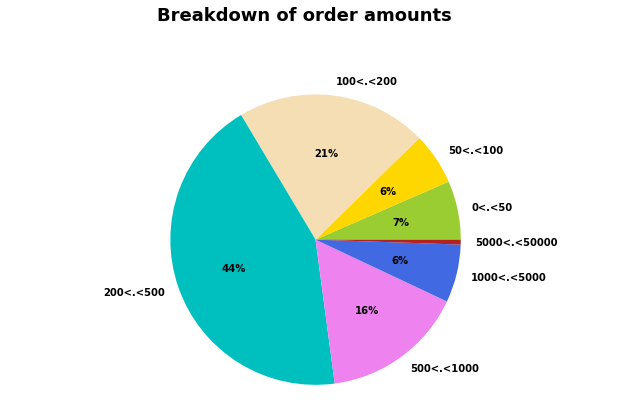

In [23]:
# Purchase account
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Breakdown of order amounts", ha='center', fontsize = 18);

It can be seen that the vast majority of orders are relatively high value purchases given that more than 66% of the purchases had a basket size (price) that is above £200.

## 3. Insight on product categories

In the dataframe, products are uniquely identified through the StockCode variable. A short description of the products is given in the Description variable. In this section, we intend to use the content of the "Description" variable in order to group the products into different categories.

### 3.1 Products Description

As a first step, we extract from the Description variable the information that will prove useful. To do this, we use the following function:

In [24]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; root = stemmer.stem(t)
            if root in keywords_roots:                
                keywords_roots[root].add(t)
                count_keywords[root] += 1                
            else:
                keywords_roots[root] = {t}
                count_keywords[root] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Number of keywords in variable '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

*   Extract the names (proper, common) appearing in the products description.
*   We extract the root of the word and aggregate the set of names associated with this particular root for each name.
*  Count the number of times each root appears in the dataframe.
*  When several words are listed for the same root, we consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants).

The first step of the analysis is to retrieve the list of products from the "Description" variable:

In [25]:
df_products = pd.DataFrame(online_retail['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, we use the function that we previously defined in order to analyze the description of the various products:

In [26]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

Number of keywords in variable 'Description': 1729


The execution of this function returns three variables:

*   Keywords: the list of extracted keywords
*   Keywords_roots: a dictionary where the keys are the keywords' roots and the values are the lists of words associated with those roots
*   Count_keywords: dictionary listing the number of times every word is used

At this point, we convert the count_keywords dictionary into a list, to sort the keywords according to their occurences:

In [27]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using list_products, we create a representation of the most common keywords:

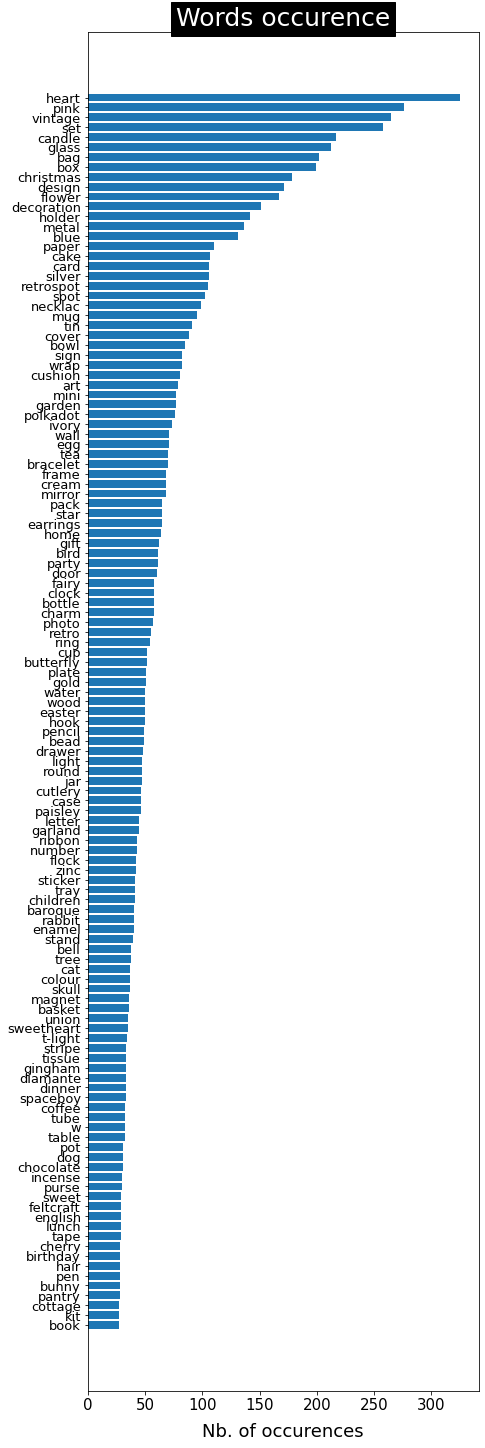

In [28]:
list_words = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in list_words[:125]]
x_axis = [k for k,i in enumerate(list_words[:125])]
x_label = [i[0] for i in list_words[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### 3.2 Defining product categories

The list that was obtained contains more than 1,400 keywords and the most frequent ones appear in more than 200 products. However, while examining the content of the list, we note that some names are not relevant. Others do not carry information, like colors. Therefore, we discard these words from the analysis that follows and also, we decide to consider only the words that appear more than 13 times.

In [29]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange', 'ass']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('preserved words:', len(list_products))

preserved words: 260


In [30]:
# the list of preserved words
list_products

[['heart', 325],
 ['vintage', 265],
 ['set', 258],
 ['candle', 217],
 ['glass', 212],
 ['bag', 202],
 ['box', 199],
 ['christmas', 178],
 ['design', 171],
 ['flower', 167],
 ['decoration', 151],
 ['holder', 142],
 ['metal', 136],
 ['paper', 110],
 ['cake', 107],
 ['card', 106],
 ['silver', 106],
 ['retrospot', 105],
 ['spot', 102],
 ['necklac', 99],
 ['mug', 95],
 ['tin', 91],
 ['cover', 88],
 ['bowl', 85],
 ['sign', 82],
 ['wrap', 82],
 ['cushion', 80],
 ['art', 79],
 ['mini', 77],
 ['garden', 77],
 ['polkadot', 76],
 ['ivory', 73],
 ['wall', 71],
 ['egg', 71],
 ['tea', 70],
 ['bracelet', 70],
 ['frame', 68],
 ['cream', 68],
 ['mirror', 68],
 ['pack', 65],
 ['star', 65],
 ['earrings', 65],
 ['home', 64],
 ['gift', 62],
 ['bird', 61],
 ['party', 61],
 ['door', 60],
 ['fairy', 58],
 ['clock', 58],
 ['bottle', 58],
 ['charm', 58],
 ['photo', 57],
 ['retro', 55],
 ['ring', 54],
 ['cup', 52],
 ['butterfly', 52],
 ['plate', 51],
 ['gold', 51],
 ['water', 50],
 ['wood', 50],
 ['easter', 50],

### 3.2.1 Data encoding

Now, we will use these keywords to create groups of products. 
First, we define the  X  matrix as:
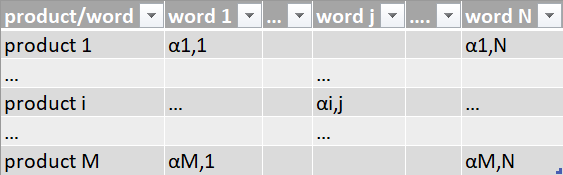

Where the  ai, j  coefficient is 1 if the description of the product i contains the word  j, and 0 otherwise.

In [31]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

In [32]:
# showing number of unique descriptions in the data set
liste_produits.shape

(5283,)

The  X  matrix indicates the words contained in the description of the products using the one-hot-encoding principle. In practice, we have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, we add 6 extra columns to this matrix, where we indicate the price range of the products:

In [33]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['Price'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

And to choose the appropriate ranges, we check the number of products in the different groups:

In [34]:
print("{:<8} {:<20} \n".format('range', 'number_products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number_products      
--------------------
0<.<1       1157                
1<.<2       1401                
2<.<3       937                 
3<.<5       857                 
5<.<10      674                 
.>10        257                 


In [35]:
X

,heart,vintage,set,candle,glass,bag,box,christmas,design,flower,decoration,holder,metal,paper,cake,card,silver,retrospot,spot,necklac,mug,tin,cover,bowl,sign,wrap,cushion,art,mini,garden,polkadot,ivory,wall,egg,tea,bracelet,frame,cream,mirror,pack,...,craft,matches,porcelain,chunky,flag,alphabet,bank,sugar,jewellery,animal,treasure,fridge,shop,pastel,circus,spoon,block,cone,doorstop,king,stick,lace,hanging,luggage,soap,handbag,decoupage,candleholder,pocket,lampshade,plant,spring,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5278,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5279,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5281,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### 3.2.2 Creating clusters of products

In this section, we will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the Hamming's metric. Note that the kmeans method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. Hence, we use the kmeans method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, we use the silhouette score:

In [36]:
# parameters
init = 'k-means++' # initialization method 

# to run 25 times with different random centroids 
# to choose the final model as the one with the lowest SSE
iterations = 25

# maximum number of iterations for each single run
max_iter = 300 

In [37]:
matrix_1 = X.to_numpy()
for n_clusters in range(3,9):
    kmeans = KMeans(init=init, n_clusters = n_clusters, n_init=iterations, random_state = 1111)
    kmeans.fit(matrix_1)
    clusters = kmeans.predict(matrix_1)
    silhouette_avg = silhouette_score(matrix_1, clusters, random_state= 1111)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.09219883195247704
For n_clusters = 4 The average silhouette_score is : 0.11513524544540599
For n_clusters = 5 The average silhouette_score is : 0.13149325960313338
For n_clusters = 6 The average silhouette_score is : 0.13360092343274158
For n_clusters = 7 The average silhouette_score is : 0.13227112587953802
For n_clusters = 8 The average silhouette_score is : 0.12943976421612555


We also show the distortion for each K value.

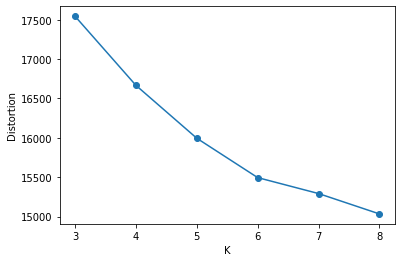

In [38]:
distortions = []

for i in range(3, 9):
    km = KMeans(i, init, n_init = iterations, max_iter= max_iter, random_state = 1111)
    labels = km.fit_predict(matrix_1)
    distortions.append(km.inertia_)

plt.plot(range(3,9), distortions, marker='o')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

Following the elbow, we set the number of clusters and train the k-means model for grouping products using 5 clusters (K=8).

In [39]:
n_clusters = 5

kmeans = KMeans(init=init, n_clusters = n_clusters, n_init=iterations, max_iter= max_iter, random_state = 1111)
kmeans.fit(matrix_1)
clusters = kmeans.predict(matrix_1)
silhouette_avg = silhouette_score(matrix_1, clusters, random_state= 1111)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.13149325960313338


### 3.2.3 Characterizing the content of product clusters

We check the number of products in each cluster:

In [40]:
pd.Series(clusters).value_counts()

0    1658
4    1157
3     937
1     857
2     674
dtype: int64

**A. Silhouette intra-cluster score**

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each cluster. This is the purpose of the next figure which is taken from [sklearn's documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

In [41]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

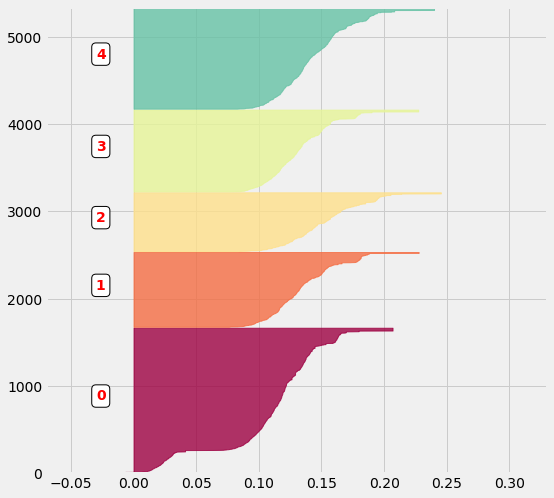

In [42]:
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix_1, clusters)
# and create the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

**B. Word Cloud**

Now we can have a look at the type of objects that each cluster represents. In order to obtain an overview of the content of each product cluster, we determine which keywords are the most frequent in each of the clusters.

In [43]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

And we output the most common words in every cluster as wordclouds:

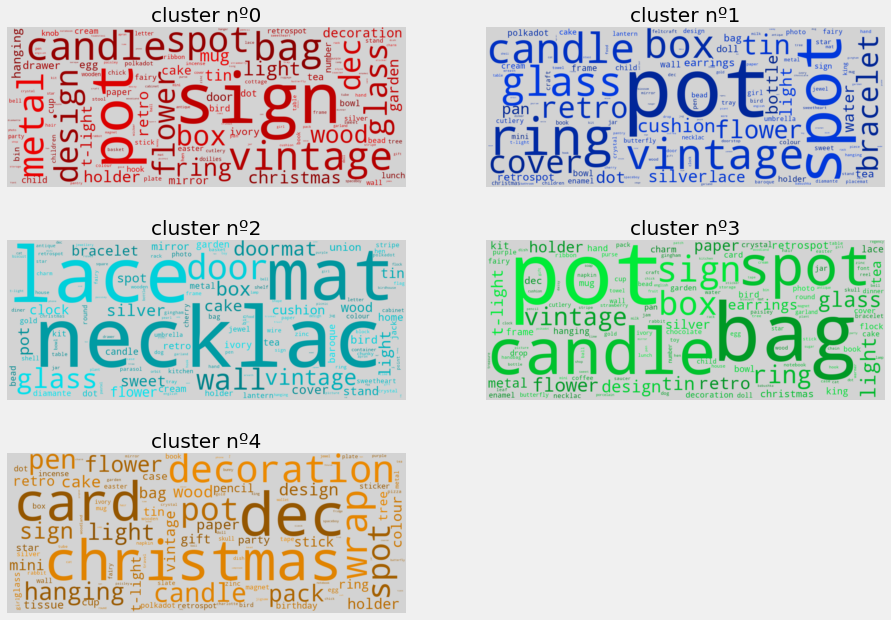

In [44]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000, height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Card, decoration, candle, gift, flower, Christmas, necklace, ring, etc.). 

Another cluster would rather contain luxury items and jewelry (keywords: ring, earings, silver, vintage, etc.). 

Nevertheless, it can also be observed that several words appear in more than one cluster and it is therefore difficult to clearly distinguish them.

In [45]:
liste_produits

array(['15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'PINK CHERRY LIGHTS',
       ' WHITE CHERRY LIGHTS', ..., 'SILVER AND BLACK ORBIT NECKLACE',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

## 4. Customer categories

### 4.1 Formatting data

In the previous section, the different products were grouped in five clusters.

In order to advance with the rest of the analysis, we introduce the product clusters into the dataframe.

To do this, we create the categorical variable categ_product where we indicate the cluster of each product in the original dataframe:

In [46]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In [47]:
clusters

array([2, 2, 2, ..., 3, 3, 3], dtype=int32)

In [48]:
#clusters_df= pd.DataFrame({'column':clusters})

In [49]:
#df_cleaned.reset_index(drop=True, inplace=True)

#df_cleaned.round({'Price': 2, 'TotalPrice': 2})

In [50]:
#from google.colab import files

#with open('df_cleaned.csv', 'w') as f:
  #df_cleaned.to_csv(f,  index = False)
  

#files.download('df_cleaned.csv')

#df_cleaned.head()

In [51]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779780 entries, 0 to 779779
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Invoice           779780 non-null  object        
 1   StockCode         779780 non-null  object        
 2   Description       779780 non-null  object        
 3   Quantity          779780 non-null  int64         
 4   InvoiceDate       779780 non-null  datetime64[ns]
 5   Price             779780 non-null  float64       
 6   Customer ID       779780 non-null  object        
 7   Country           779780 non-null  object        
 8   QuantityCanceled  779780 non-null  int64         
 9   TotalPrice        779780 non-null  float64       
 10  categ_product     779780 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 65.4+ MB


### 4.1.1 Grouping products

In the next step, we create the categ_N variables (with N∈[0:4] ) to fill in the total amount spent per row (in each product and invoice) in each product category:

In [52]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['Price'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['Invoice', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:8]

,Invoice,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,489434,15CM CHRISTMAS GLASS BALL 20 LIGHTS,2,0.0,0.0,83.4,0.0,0.0
1,489434,PINK CHERRY LIGHTS,2,0.0,0.0,81.0,0.0,0.0
2,489434,WHITE CHERRY LIGHTS,2,0.0,0.0,81.0,0.0,0.0
3,489434,"RECORD FRAME 7"" SINGLE SIZE",3,0.0,0.0,0.0,100.8,0.0
4,489434,STRAWBERRY CERAMIC TRINKET BOX,0,30.0,0.0,0.0,0.0,0.0
5,489434,PINK DOUGHNUT TRINKET POT,0,39.6,0.0,0.0,0.0,0.0
6,489434,SAVE THE PLANET MUG,0,30.0,0.0,0.0,0.0,0.0
7,489434,FANCY FONT HOME SWEET HOME DOORMAT,2,0.0,0.0,59.5,0.0,0.0


Up till now, the information related to a single order was split over several rows of the dataframe (one rows per product). In the next step we group the information related to a particular order in a single entry.

In other words, we summarize the orders by customers and invoice.  

We therefore create a new dataframe that contains, for each order, the total amount of their final purchase, as well as the way it is distributed over the 5 categories of products:

In [53]:
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# percentage of order price / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 

# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('Customer ID', ascending = True)[:15]

,Customer ID,Invoice,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12346,491725,45.00,0.00,45.00,0.00,0.00,0.00,2009-12-14 08:34:00.000000000
1,12346,491742,22.50,0.00,22.50,0.00,0.00,0.00,2009-12-14 11:00:00.000000000
2,12346,491744,22.50,0.00,22.50,0.00,0.00,0.00,2009-12-14 11:02:00.000000000
3,12346,492718,22.50,0.00,22.50,0.00,0.00,0.00,2009-12-18 10:47:00.000000000
4,12346,492722,1.00,0.00,1.00,0.00,0.00,0.00,2009-12-18 10:55:00.000000000
5,12346,493410,22.50,0.00,22.50,0.00,0.00,0.00,2010-04-01 09:24:00.000000000
6,12346,493412,22.50,0.00,22.50,0.00,0.00,0.00,2010-04-01 09:53:00.000000000
7,12346,494450,22.50,0.00,22.50,0.00,0.00,0.00,2010-01-14 13:50:00.000000000
8,12346,495295,18.00,0.00,18.00,0.00,0.00,0.00,2010-01-22 13:30:00.000000000
9,12346,499763,27.05,0.00,3.25,23.80,0.00,0.00,2010-02-03 13:08:00.000000000


### 4.1.2 Separation of data over time

The dataframe basket_price contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site after their first visit. In order to be able to test the model in a realistic way, we split the data set by retaining the first 10 months to train the models and the following two months to test it:

In [54]:
#show the date range of the original dataset
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2009-01-12 07:45:00 -> 2011-12-10 17:18:59.999999488


In [55]:
set_training= basket_price[basket_price['InvoiceDate'].dt.date < datetime.date(2011,10,1)]
set_test= basket_price[basket_price['InvoiceDate'].dt.date >= datetime.date(2011,10,1)]
basket_price= set_training.copy(deep = True)

### 4.1.3 Consumer Order Combinations

In the next step, we group together the different observations that correspond to the same user. 

We thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [56]:
# number of visits and stats on the amount of the cart / users
transactions_per_user_1=basket_price.groupby(by=['Customer ID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user_1.loc[:,col] = basket_price.groupby(by=['Customer ID'])[col].sum() /\
                                            transactions_per_user_1['sum']*100

transactions_per_user_1.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['Customer ID'])['categ_0'].sum()
transactions_per_user_1.sort_values('Customer ID', ascending = True)[:5]

,Customer ID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12346,11,1.00,142.31,33.487273,368.36,0.000000,54.905527,45.094473,0.000000,0.000000
1,12347,7,224.82,711.79,518.172857,3627.21,34.527915,25.580818,7.502736,17.980762,14.407768
2,12348,5,222.16,892.80,403.880000,2019.40,58.660988,0.000000,0.000000,0.000000,41.339012
3,12349,3,200.00,1402.62,890.380000,2671.14,52.275433,6.238909,24.998315,8.850154,7.637189
4,12350,1,334.40,334.40,334.400000,334.40,60.406699,0.000000,0.000000,27.900718,11.692584


Finally, we define two additional variables that give the number of days elapsed since the first purchase ("First Purchase") and the number of days since the last purchase ("Last Purchase"):

In [57]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration= pd.DataFrame(basket_price.groupby(by=['Customer ID'])['InvoiceDate'].min())
last_purchase= pd.DataFrame(basket_price.groupby(by=['Customer ID'])['InvoiceDate'].max())

test= first_registration.applymap(lambda x:(last_date - x.date()).days)
test2= last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user_1.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user_1.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user_1[:5]

,Customer ID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12346,11,1.00,142.31,33.487273,368.36,0.000000,54.905527,45.094473,0.000000,0.000000,459,655
1,12347,7,224.82,711.79,518.172857,3627.21,34.527915,25.580818,7.502736,17.980762,14.407768,24,445
2,12348,5,222.16,892.80,403.880000,2019.40,58.660988,0.000000,0.000000,0.000000,41.339012,5,368
3,12349,3,200.00,1402.62,890.380000,2671.14,52.275433,6.238909,24.998315,8.850154,7.637189,337,519
4,12350,1,334.40,334.40,334.400000,334.40,60.406699,0.000000,0.000000,27.900718,11.692584,240,240


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, we find that this type of customers represents almost 1/3 of the customers:

In [58]:
n1= transactions_per_user_1[transactions_per_user_1['count'] == 1].shape[0]
n2= transactions_per_user_1.shape[0]
print("number of customers with a single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

number of customers with a single purchase: 1666/5578  (29.87%)


### 4.2 Creation of customers categories

**4.2.1 Data encoding**

The dataframe transactions_per_user_1 contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. We use this information to characterize the different types of customers and only keep a subset of variables:

In [59]:
transactions_per_user_1

,Customer ID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12346,11,1.00,142.31,33.487273,368.36,0.000000,54.905527,45.094473,0.000000,0.000000,459,655
1,12347,7,224.82,711.79,518.172857,3627.21,34.527915,25.580818,7.502736,17.980762,14.407768,24,445
2,12348,5,222.16,892.80,403.880000,2019.40,58.660988,0.000000,0.000000,0.000000,41.339012,5,368
3,12349,3,200.00,1402.62,890.380000,2671.14,52.275433,6.238909,24.998315,8.850154,7.637189,337,519
4,12350,1,334.40,334.40,334.400000,334.40,60.406699,0.000000,0.000000,27.900718,11.692584,240,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,18283,17,2.50,208.00,112.600000,1914.20,44.281162,8.280222,6.598057,26.504023,14.336537,78,604
5574,18284,1,411.68,411.68,411.680000,411.68,13.772833,15.060241,0.000000,20.987175,50.179751,538,538
5575,18285,1,427.00,427.00,427.000000,427.00,26.580796,4.637002,16.791569,47.775176,4.215457,590,590
5576,18286,2,354.95,833.48,594.215000,1188.43,43.502773,9.613524,17.884099,17.089774,14.181736,406,653


In [60]:
list_cols= ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
selected_customers = transactions_per_user_1.copy(deep= True)
matrix_2 = selected_customers[list_cols].to_numpy()
matrix_2

array([[1.10000000e+01, 1.00000000e+00, 1.42310000e+02, ...,
        4.50944728e+01, 0.00000000e+00, 0.00000000e+00],
       [7.00000000e+00, 2.24820000e+02, 7.11790000e+02, ...,
        7.50273626e+00, 1.79807621e+01, 1.44077680e+01],
       [5.00000000e+00, 2.22160000e+02, 8.92800000e+02, ...,
        0.00000000e+00, 0.00000000e+00, 4.13390116e+01],
       ...,
       [1.00000000e+00, 4.27000000e+02, 4.27000000e+02, ...,
        1.67915691e+01, 4.77751756e+01, 4.21545667e+00],
       [2.00000000e+00, 3.54950000e+02, 8.33480000e+02, ...,
        1.78840992e+01, 1.70897739e+01, 1.41817356e+01],
       [5.00000000e+00, 3.06000000e+01, 1.07161000e+03, ...,
        2.75475010e+00, 2.34311264e+01, 7.26071122e+00]])

In practice, the variables that we selected have quite different ranges of variation and before continuing the analysis, we create a matrix where these data are standardized:

In [61]:
scaler = StandardScaler()
scaler.fit(matrix_2)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix_2)

variables mean values: 
------------------------------------------------------------------------------------------
 [  5.77949086 216.54018196 608.44432682 363.76064872  35.12176428
  16.38578916  15.39737702  19.07968502  14.03717672]


**4.2.2 Creation of customer categories**

At this point, we define clusters of clients using the k-means algorithm from scikit-learn. We choose the number of clusters based on the silhouette score and we find that the best score is obtained with 11 clusters:

In [62]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100, random_state = 1111)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.181


At first, we look at the number of customers in each cluster:

In [63]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['number of clients']).T

,7,5,10,2,9,1,8,0,6,4,3
number of clients,1873,1716,554,496,295,267,263,86,20,5,3


**A. Intra-cluster Silhouette Score**

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

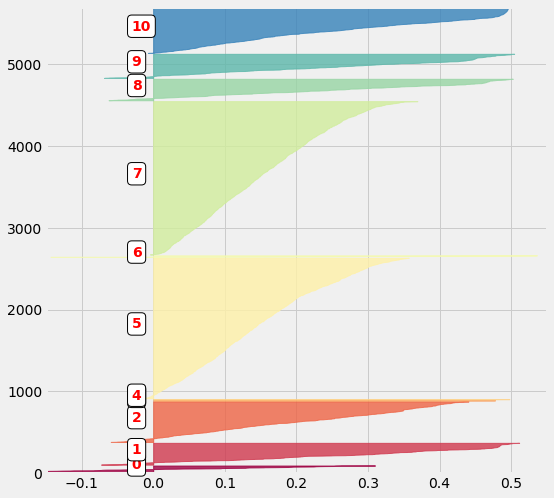

In [64]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

**B. Customers morphotype**

At this stage, we have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, we start by adding to the selected_customers dataframe a variable that defines the cluster to which each client belongs:

In [65]:
selected_customers.loc[:, 'cluster'] = clusters_clients
selected_customers

,Customer ID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,12346,11,1.00,142.31,33.487273,368.36,0.000000,54.905527,45.094473,0.000000,0.000000,459,655,9
1,12347,7,224.82,711.79,518.172857,3627.21,34.527915,25.580818,7.502736,17.980762,14.407768,24,445,7
2,12348,5,222.16,892.80,403.880000,2019.40,58.660988,0.000000,0.000000,0.000000,41.339012,5,368,7
3,12349,3,200.00,1402.62,890.380000,2671.14,52.275433,6.238909,24.998315,8.850154,7.637189,337,519,7
4,12350,1,334.40,334.40,334.400000,334.40,60.406699,0.000000,0.000000,27.900718,11.692584,240,240,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,18283,17,2.50,208.00,112.600000,1914.20,44.281162,8.280222,6.598057,26.504023,14.336537,78,604,7
5574,18284,1,411.68,411.68,411.680000,411.68,13.772833,15.060241,0.000000,20.987175,50.179751,538,538,1
5575,18285,1,427.00,427.00,427.000000,427.00,26.580796,4.637002,16.791569,47.775176,4.215457,590,590,2
5576,18286,2,354.95,833.48,594.215000,1188.43,43.502773,9.613524,17.884099,17.089774,14.181736,406,653,7


Then, we average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. We also determine the number of clients in each group (variable size):

In [66]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

merged_df.drop('Customer ID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')
merged_df

number of customers: 5578


,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,size
cluster,,,,,,,,,,,,,
1.0,2.625468,188.895056,333.233071,252.665551,713.907528,20.847012,5.419371,4.286551,7.928036,61.519030,260.689139,418.397004,267
10.0,2.882671,174.520776,330.228105,245.818863,782.207475,72.635168,6.079903,6.770078,7.767034,6.757782,254.196751,414.601083,554
2.0,3.441532,183.020548,401.970063,274.788514,1042.720548,23.526085,10.991646,8.490069,48.914660,8.102567,244.812500,443.665323,496
9.0,3.149153,175.309932,356.352508,249.587664,1069.191492,15.416477,58.657539,8.392073,11.664487,5.870994,257.803390,433.847458,295
8.0,3.707224,203.131635,368.668137,276.996623,1098.961217,15.149998,9.343856,62.939498,8.217937,4.355054,285.547529,477.733840,263
7.0,5.601175,219.742579,593.369386,378.598159,2175.489265,39.545586,14.267124,8.394825,19.196810,18.625806,174.560598,472.366791,1873
5.0,6.902098,172.807973,555.177262,326.419729,2488.065855,30.037085,19.182619,23.571678,18.538228,8.696236,186.177156,507.653846,1716
3.0,1.000000,14764.640000,14764.640000,14764.640000,14764.640000,18.876217,26.044825,7.810936,32.092998,15.175024,342.333333,342.333333,3
0.0,8.860465,1301.502221,4574.084081,2295.954472,16754.613163,38.840739,14.741873,12.888626,20.663262,12.867176,185.197674,442.500000,86


Finally, we re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount spent in each product category and then, according to the total amount spent:

In [67]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 5].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,1.0,2.625468,188.895056,333.233071,252.665551,713.907528,20.847012,5.419371,4.286551,7.928036,61.519030,267
1,1.0,2.625468,188.895056,333.233071,252.665551,713.907528,20.847012,5.419371,4.286551,7.928036,61.519030,267
2,10.0,2.882671,174.520776,330.228105,245.818863,782.207475,72.635168,6.079903,6.770078,7.767034,6.757782,554
3,1.0,2.625468,188.895056,333.233071,252.665551,713.907528,20.847012,5.419371,4.286551,7.928036,61.519030,267
4,1.0,2.625468,188.895056,333.233071,252.665551,713.907528,20.847012,5.419371,4.286551,7.928036,61.519030,267
5,2.0,3.441532,183.020548,401.970063,274.788514,1042.720548,23.526085,10.991646,8.490069,48.914660,8.102567,496
6,9.0,3.149153,175.309932,356.352508,249.587664,1069.191492,15.416477,58.657539,8.392073,11.664487,5.870994,295
7,8.0,3.707224,203.131635,368.668137,276.996623,1098.961217,15.149998,9.343856,62.939498,8.217937,4.355054,263
8,7.0,5.601175,219.742579,593.369386,378.598159,2175.489265,39.545586,14.267124,8.394825,19.196810,18.625806,1873
9,5.0,6.902098,172.807973,555.177262,326.419729,2488.065855,30.037085,19.182619,23.571678,18.538228,8.696236,1716


**C. Customers morphology**

Finally, we created a representation of the different morphotypes. To do this, we define a class to create "Radar Charts".

In [68]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

This allows to have a global view of the content of each cluster:

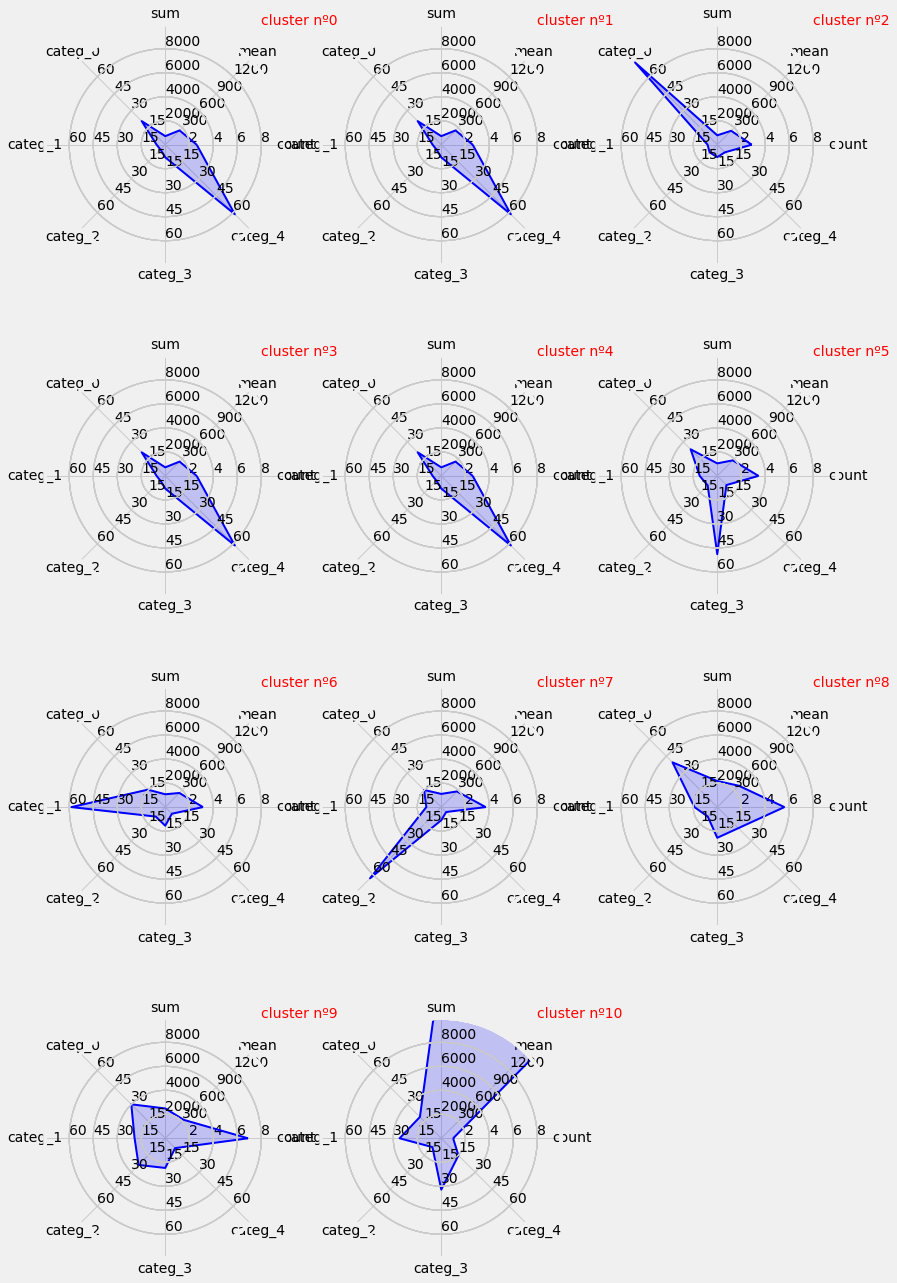

In [69]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

We see that several clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (mean), the total sum spent by the clients (sum) or the total number of purchases made (count).

In [70]:
selected_customers

,Customer ID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,12346,11,1.00,142.31,33.487273,368.36,0.000000,54.905527,45.094473,0.000000,0.000000,459,655,9
1,12347,7,224.82,711.79,518.172857,3627.21,34.527915,25.580818,7.502736,17.980762,14.407768,24,445,7
2,12348,5,222.16,892.80,403.880000,2019.40,58.660988,0.000000,0.000000,0.000000,41.339012,5,368,7
3,12349,3,200.00,1402.62,890.380000,2671.14,52.275433,6.238909,24.998315,8.850154,7.637189,337,519,7
4,12350,1,334.40,334.40,334.400000,334.40,60.406699,0.000000,0.000000,27.900718,11.692584,240,240,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,18283,17,2.50,208.00,112.600000,1914.20,44.281162,8.280222,6.598057,26.504023,14.336537,78,604,7
5574,18284,1,411.68,411.68,411.680000,411.68,13.772833,15.060241,0.000000,20.987175,50.179751,538,538,1
5575,18285,1,427.00,427.00,427.000000,427.00,26.580796,4.637002,16.791569,47.775176,4.215457,590,590,2
5576,18286,2,354.95,833.48,594.215000,1188.43,43.502773,9.613524,17.884099,17.089774,14.181736,406,653,7


In [71]:
# from google.colab import files

# with open('selected_customers.csv', 'w') as f:
#   selected_customers.to_csv(f,  index = False)
  

# files.download('selected_customers.csv')

# selected_customers.head()

## 5. Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, we will test several classifiers implemented in scikit-learn. First, in order to simplify their use, we define a class that allows controling several of the functionalities common to these different classifiers:

In [72]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

Since the goal is to define the class to which a client belongs to from her/his first visit, we only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [73]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = selected_customers[columns]
Y = selected_customers['cluster']

In [74]:
X

,mean,categ_0,categ_1,categ_2,categ_3,categ_4
0,33.487273,0.000000,54.905527,45.094473,0.000000,0.000000
1,518.172857,34.527915,25.580818,7.502736,17.980762,14.407768
2,403.880000,58.660988,0.000000,0.000000,0.000000,41.339012
3,890.380000,52.275433,6.238909,24.998315,8.850154,7.637189
4,334.400000,60.406699,0.000000,0.000000,27.900718,11.692584
...,...,...,...,...,...,...
5573,112.600000,44.281162,8.280222,6.598057,26.504023,14.336537
5574,411.680000,13.772833,15.060241,0.000000,20.987175,50.179751
5575,427.000000,26.580796,4.637002,16.791569,47.775176,4.215457
5576,594.215000,43.502773,9.613524,17.884099,17.089774,14.181736


In [75]:
Y

0        9
1        7
2        7
3        7
4       10
        ..
5573     7
5574     1
5575     2
5576     7
5577     7
Name: cluster, Length: 5578, dtype: int32

Finally, we split the dataset in train and test sets:

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7, random_state= 1111)

### 5.1 Support Vector Machine Classifier (SVC)

The first classifier that we use is the SVC classifier. In order to use it, we create an instance of LinearSVC.

In [77]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10), 'dual': [False]}], Kfold = 5)

In [78]:
svc.grid_fit(X = X_train, Y = Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Then we test the quality of the prediction with respect to the test data:

In [79]:
svc.grid_predict(X_test, Y_test)

Precision: 92.29 % 


**5.1.1 Confusion matrix**

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained.

In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare within the different clusters. 

This is the subject of the confusion matrices and to represent them, we use the code of [the sklearn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [80]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [81]:
Y_test

1955     2
43       7
927      0
3973     9
929      5
        ..
1731    10
2439     1
1894     7
4677     0
3040     5
Name: cluster, Length: 1674, dtype: int32

From which we create the following representation:

Confusion matrix, without normalization


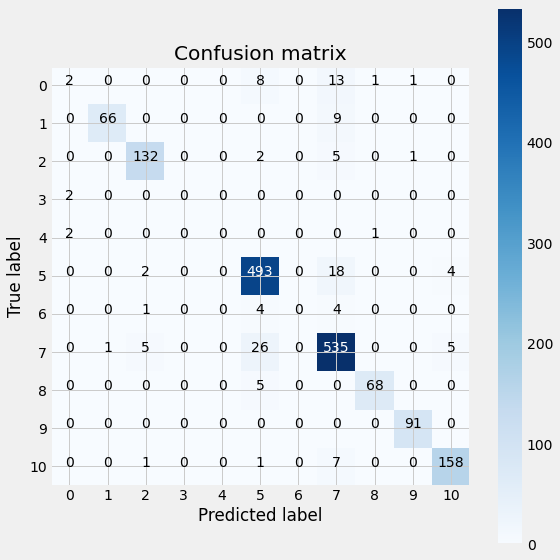

In [82]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

### **5.1.2 Learning curve**

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting.

This also shows to which extent the model could benefit from a larger data sample. In order to draw this curve, we use the [scikit-learn documentation code again](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-%20self-examples-model-selection-pad-learning-curve-py).

In [83]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### 5.2 Logistic Regression

We now consider the logistic regression classifier. As before, I create an instance of the Class_Fit class, adjust the model on the training data and see how the predictions compare to the real values:

In [84]:
X_train

,mean,categ_0,categ_1,categ_2,categ_3,categ_4
1262,673.466667,20.134627,2.227282,61.334389,11.581865,4.721837
5214,203.860000,1.226332,0.000000,0.000000,3.924262,94.849406
56,1710.390000,30.212992,18.574711,19.334772,19.382129,12.495396
4479,119.515000,34.419320,22.108104,13.000460,21.299628,9.172489
2390,276.682500,60.552258,6.496616,3.225719,18.297146,11.428262
...,...,...,...,...,...,...
3468,299.878000,53.556446,1.860757,7.106223,28.731684,8.744890
3409,446.962000,35.731002,12.229228,11.390230,28.422998,12.226543
2789,52.000000,100.000000,0.000000,0.000000,0.000000,0.000000
311,4873.810000,40.490294,15.921835,10.918563,18.582587,14.086721


In [85]:
Y_train

1262     8
5214     1
56       0
4479     5
2390    10
        ..
3468     7
3409     7
2789    10
311      0
2460     5
Name: cluster, Length: 3904, dtype: int32

In [86]:
X_test

,mean,categ_0,categ_1,categ_2,categ_3,categ_4
1955,406.966667,9.877959,5.373085,34.130559,44.327955,6.290441
43,451.916000,38.865187,20.229423,13.248037,18.058666,9.598686
927,2059.362000,44.612361,14.158997,16.206476,17.861503,7.160664
3973,175.112500,0.000000,78.806482,16.139625,5.053894,0.000000
929,303.930000,38.462804,24.216102,10.808410,20.399434,6.113250
...,...,...,...,...,...,...
1731,79.900000,100.000000,0.000000,0.000000,0.000000,0.000000
2439,179.400000,37.123746,19.732441,0.000000,0.000000,43.143813
1894,317.340000,34.757673,19.127749,3.135438,17.583664,25.395475
4677,2255.880000,70.189904,0.000000,0.000000,0.000000,29.810096


In [87]:
lr = LogisticRegression(max_iter=10000, random_state= 1111)
lr = lr.fit(X_train,Y_train)
lr.predict(X_test)
lr.score(X_test, Y_test)

0.9605734767025089

In [88]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20), 'dual': [False],}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docu

Precision: 94.27 % 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### 5.3 k-Nearest Neighbors

In [89]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Precision: 82.38 % 


### 5.4 Decision Tree

In [90]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Precision: 89.96 % 


### 5.5 Random Forest

In [91]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 2)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.



Precision: 93.25 % 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.



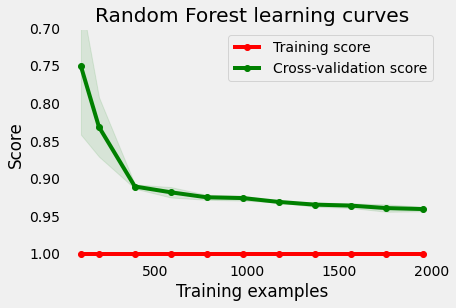

In [92]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 2, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.6 AdaBoost Classifier

In [93]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 2)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.



Precision: 59.50 % 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.



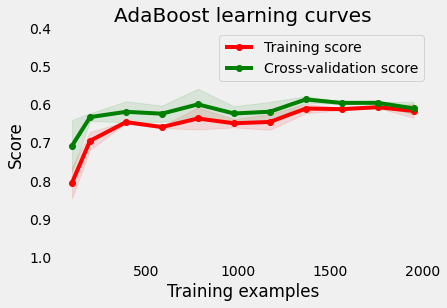

In [94]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 2, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.7 Gradient Boosting Classifier

In [95]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 2)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.



Precision: 94.27 % 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.



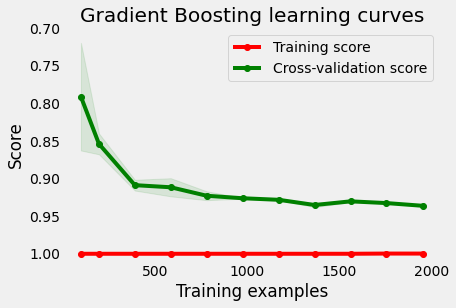

In [96]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 2, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.8 Let's vote !

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, we use the VotingClassifier method of the sklearn package. As a first step, we adjust the parameters of the various classifiers using the best parameters previously found:

In [97]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, we define a classifier that merges the results of the various classifiers:

In [98]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft') 

and train it:

In [99]:
votingC = votingC.fit(X_train, Y_train)

Finally, we create a prediction using this ensemble model:

In [100]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 93.55 % 


Note that when defining the votingC classifier, we only used a sub-sample of the whole set of classifiers defined above and only retained the Random Forest, the k-Nearest Neighbors and the Gradient Boosting classifiers.

In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

## 6. Testing predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the models' training and predictions were based on the data of the first 10 months. 

In this section, we test the model on the last two months of the dataset, that has been stored in the set_test dataframe:

In [101]:
basket_price = set_test.copy(deep = True)
basket_price = basket_price.reset_index(drop=True)

In [102]:
basket_price

,Customer ID,Invoice,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12347,573511,1294.32,277.10,392.12,55.60,424.20,145.30,2011-10-31 12:25:00.000001280
1,12349,577609,1757.55,928.06,188.30,358.35,203.52,79.32,2011-11-21 09:51:00.000000256
2,12356,576895,58.35,58.35,0.00,0.00,0.00,0.00,2011-11-17 08:40:00.000000000
3,12358,559707,484.86,130.76,15.00,321.40,17.70,0.00,2011-12-07 10:04:00.000000000
4,12359,540946,547.50,351.70,45.30,97.80,52.70,0.00,2011-12-01 12:43:00.000000000
...,...,...,...,...,...,...,...,...,...
4478,18283,575675,1.95,1.95,0.00,0.00,0.00,0.00,2011-10-11 15:07:00.000000000
4479,18283,578262,307.05,111.08,0.00,0.00,127.93,68.04,2011-11-23 13:27:00.000002048
4480,18283,579673,220.31,97.32,9.75,0.00,83.59,29.65,2011-11-30 12:58:59.999998720
4481,18287,570715,1001.32,423.88,32.00,0.00,326.04,219.40,2011-12-10 10:22:59.999998720


In a first step, we regroup these data according to the same procedure applied to the training set. 

However, we are correcting the data to take into account the difference in time between the two datasets and weights the variables count and sum to obtain an equivalence with the training set:

In [103]:
transactions_per_user_2=basket_price.groupby(by=['Customer ID'])['Basket Price'].agg(['count','min','max','mean','sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user_2.loc[:,col] = basket_price.groupby(by=['Customer ID'])[col].sum() /\
                                            transactions_per_user_2['sum']*100

transactions_per_user_2.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['Customer ID'])['categ_0'].sum()

# Correcting time range
transactions_per_user_2['count'] = 5 * transactions_per_user_2['count']
transactions_per_user_2['sum']   = transactions_per_user_2['count'] * transactions_per_user_2['mean']

transactions_per_user_2.sort_values('Customer ID', ascending = True)[:5]

,Customer ID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,1294.32,1294.32,1294.32,6471.60,21.408925,30.295445,4.295692,32.773966,11.225972
1,12349,5,1757.55,1757.55,1757.55,8787.75,52.804188,10.713778,20.389178,11.579756,4.513101
2,12356,5,58.35,58.35,58.35,291.75,100.000000,0.000000,0.000000,0.000000,0.000000
3,12358,5,484.86,484.86,484.86,2424.30,26.968609,3.093677,66.287176,3.650538,0.000000
4,12359,10,547.50,2814.30,1680.90,16809.00,51.253793,21.049735,18.992801,8.403831,0.299839


In [104]:
selected_customers

,Customer ID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,12346,11,1.00,142.31,33.487273,368.36,0.000000,54.905527,45.094473,0.000000,0.000000,459,655,9
1,12347,7,224.82,711.79,518.172857,3627.21,34.527915,25.580818,7.502736,17.980762,14.407768,24,445,7
2,12348,5,222.16,892.80,403.880000,2019.40,58.660988,0.000000,0.000000,0.000000,41.339012,5,368,7
3,12349,3,200.00,1402.62,890.380000,2671.14,52.275433,6.238909,24.998315,8.850154,7.637189,337,519,7
4,12350,1,334.40,334.40,334.400000,334.40,60.406699,0.000000,0.000000,27.900718,11.692584,240,240,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,18283,17,2.50,208.00,112.600000,1914.20,44.281162,8.280222,6.598057,26.504023,14.336537,78,604,7
5574,18284,1,411.68,411.68,411.680000,411.68,13.772833,15.060241,0.000000,20.987175,50.179751,538,538,1
5575,18285,1,427.00,427.00,427.000000,427.00,26.580796,4.637002,16.791569,47.775176,4.215457,590,590,2
5576,18286,2,354.95,833.48,594.215000,1188.43,43.502773,9.613524,17.884099,17.089774,14.181736,406,653,7


Then, we convert the dataframe into a matrix and retain only variables that define the category to which consumers belong to. At this level, we recall the method of normalization that had been used on the training set:

In [105]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

matrix_test = transactions_per_user_2[list_cols].to_numpy()
scaled_test_matrix = scaler.transform(matrix_test)

In [106]:
scaled_test_matrix.shape

(2292, 9)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself. Here, we prepare the test data by defining the category to which the customers belong to. However, this definition uses data obtained over a period of 2 months (including the variables count, min , max and sum). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong to, we recall the instance of the kmeans method used in section 4. The predict method of this instance calculates the distance of the consumers from the centroids of the 11 client clusters and the smallest distance will define the category that each client belongs to:

In [107]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts on:

In [108]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = transactions_per_user_2[columns]

In [109]:
Y

array([ 7,  0, 10, ..., 10,  2,  7], dtype=int32)

In [110]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 91.06 % 
______________________________ 
Logostic Regression
Precision: 93.59 % 
______________________________ 
k-Nearest Neighbors
Precision: 82.16 % 
______________________________ 
Decision Tree
Precision: 89.22 % 
______________________________ 
Random Forest
Precision: 93.59 % 
______________________________ 
Gradient Boosting
Precision: 93.63 % 


Finally, as anticipated in Section 5.8, it is possible to improve the quality of the classifiers by combining their respective predictions. At this level, we chose to mix Random Forest, Gradient Boosting and k-Nearest Neighbors predictions because this leads to a slight improvement in predictions:

In [111]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 94.42 % 


In [112]:
predictions

array([ 0,  0, 10, ..., 10,  2,  7], dtype=int32)

## 7. Conclusion

The work described in this notebook is based on a database providing details on purchases made on an E-commerce platform over a period of one year. Each entry in the dataset describes the purchase of a product, by a particular customer and at a given date. In total, approximately  ∼ 4,000 clients appear in the database. Given the available information, We decided to develop a classifier that allows to anticipate the type of purchase that a customer will make, as well as the number of visits that the customer will make during a year, after the customer's first visit to the E-commerce site.

The first stage of this work consisted in describing the different products sold by the site, which was the subject of a first classification. There, we grouped the different products into 5 main categories of goods. In a second step, we performed a classification of the customers by analyzing their consumption habits over a period of 10 months. We classified clients into 11 major categories based on the type of products they usually buy, the number of visits they make and the amount they spent during the 10 months. Once these categories established, and we finally trained several classifiers whose objective is to be able to classify consumers in one of these 11 categories after their first purchase. For this, the classifier is based on 8 variables which are:

*   **mean**: amount of the basket of the current purchase
*   **categ_N** with  N∈[0:7]: percentage spent in product category with index  N

Finally, the quality of the predictions of the different classifiers was tested over the last two months of the dataset. The data were then processed in two steps: first, all the data was considered (for 2 months) to define the category to which each client belongs to, and then, the classifier predictions were compared with this category assignment. We then found that 94% of the clients were assigned the right classes. The performance of the classifier therefore seems correct given the potential shortcomings of the current model. In particular, a bias that has not been dealt with concerns the seasonality of purchases and the fact that purchasing habits will potentially depend on the time of year (for example, Christmas). In practice, this seasonal effect may cause the categories defined over a 10-month period to be quite different from those extrapolated from the last two months. In order to correct such bias, it would be beneficial to have data that would cover a longer period of time.